## Futures Spread Dynamics - Jingwen Li

In [10]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy as sp
import quandl
import functools
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')

In [19]:
@functools.lru_cache(maxsize=1600)
def fetch_quandl(my_data_items, trim_start=None, trim_end=None):
    qdata = quandl.get(list(my_data_items), returns="pandas", 
                      trim_start=trim_start, trim_end=trim_end,
                      api_key='key')
    return qdata

In [20]:
def clean_quandl_columns(dataframe):
    replacement_columns = {}
    for c in dataframe.columns:
        series_name, variable = c.split(' - ')
        source_name, asset = series_name.split('/')
        replacement_columns[c] = variable
    renamed_data = dataframe.rename(columns=replacement_columns)
    return renamed_data

### 1. Pulling data from Quandl

In [21]:
l = []
for i in ['H','M','U','Z']:
    for j in range(2020,2023):
        emini_contracts = f'OWF/CBT_FV_FV_{i}{j}_IVM' 
        es_option_data = clean_quandl_columns(fetch_quandl((emini_contracts,),
                                                   trim_start="2020-12-03", 
                                                   trim_end="2022-08-31")
                                     )
        l.append(es_option_data)
        CBT_FV_FV = pd.concat(l)
CBT_FV_FV = CBT_FV_FV [CBT_FV_FV.DtT > 30]
CBT_FV_FV = CBT_FV_FV.sort_values('DtT')
CBT_FV_FV = CBT_FV_FV [~CBT_FV_FV.index.duplicated()].sort_index()
df_FV = CBT_FV_FV.iloc[:,0].to_frame()
df_FV.columns = ['5Yr']
df_FV


,5Yr
2020-12-03,125.820312
2020-12-04,125.734375
2020-12-07,125.898438
2020-12-08,125.906250
2020-12-09,125.812500
...,...
2022-08-25,111.359375
2022-08-26,111.218750
2022-08-29,110.890625
2022-08-30,110.820312


In [22]:
l = []
for i in ['H','M','U','Z']:
    for j in range(2020,2023):
        emini_contracts = f'OWF/CBT_TU_TU_{i}{j}_IVM' 
        es_option_data = clean_quandl_columns(fetch_quandl((emini_contracts,),
                                                   trim_start="2020-12-03", 
                                                   trim_end="2022-08-31")
                                     )
        l.append(es_option_data)
        CBT_TU_TU = pd.concat(l)
CBT_TU_TU = CBT_TU_TU [CBT_TU_TU.DtT > 30]
CBT_TU_TU = CBT_TU_TU.sort_values('DtT')
CBT_TU_TU = CBT_TU_TU [~CBT_TU_TU.index.duplicated()].sort_index()
df_TU = CBT_TU_TU.iloc[:,0].to_frame()
df_TU.columns = ['2Yr']
df_TU = df_TU * 1.1066
df_TU

,2Yr
2020-12-03,122.161724
2020-12-04,122.168640
2020-12-07,122.192847
2020-12-08,122.175556
2020-12-09,122.168640
...,...
2022-08-25,115.579183
2022-08-26,115.440858
2022-08-29,115.337114
2022-08-30,115.245474


In [23]:
l = []
for i in ['H','M','U','Z']:
    for j in range(2020,2023):
        emini_contracts = f'OWF/CBT_TY_TY_{i}{j}_IVM' 
        es_option_data = clean_quandl_columns(fetch_quandl((emini_contracts,),
                                                   trim_start="2020-12-03", 
                                                   trim_end="2022-08-31")
                                     )
        l.append(es_option_data)
        CBT_TY_TY = pd.concat(l)
CBT_TY_TY = CBT_TY_TY [CBT_TY_TY.DtT > 30]
CBT_TY_TY = CBT_TY_TY.sort_values('DtT')
CBT_TY_TY = CBT_TY_TY [~CBT_TY_TY.index.duplicated()].sort_index()
df_TY = CBT_TY_TY.iloc[:,0].to_frame()
df_TY.columns = ['10Yr']
df_TY = df_TY * 0.9338
df_TY

,10Yr
2020-12-03,128.543406
2020-12-04,128.280775
2020-12-07,128.601769
2020-12-08,128.689312
2020-12-09,128.514225
...,...
2022-08-25,110.086266
2022-08-26,109.881997
2022-08-29,109.356734
2022-08-30,109.327553


### 2. Combining data and getting all the metrics

In [24]:
df_q3= pd.merge(df_FV, df_TU, left_index=True, right_index=True, how = 'inner')
df_q3['Spread'] = df_q3['2Yr'] - df_q3['5Yr']
df_q3['Rolling Avg 10d'] = df_q3['Spread'].rolling(10).mean()
df_q3['Diff 10d'] = df_q3['Spread'] - df_q3['Rolling Avg 10d']
df_q3['Rolling Avg 50d'] = df_q3['Spread'].rolling(50).mean()
df_q3['Diff 50d'] = df_q3['Spread'] - df_q3['Rolling Avg 50d']
df_q3['Rolling Avg 100d'] = df_q3['Spread'].rolling(100).mean()
df_q3['Diff 100d'] = df_q3['Spread'] - df_q3['Rolling Avg 100d']
df_q3.round(2)

,5Yr,2Yr,Spread,Rolling Avg 10d,Diff 10d,Rolling Avg 50d,Diff 50d,Rolling Avg 100d,Diff 100d
2020-12-03,125.82,122.16,-3.66,NaN,NaN,NaN,NaN,NaN,NaN
2020-12-04,125.73,122.17,-3.57,NaN,NaN,NaN,NaN,NaN,NaN
2020-12-07,125.90,122.19,-3.71,NaN,NaN,NaN,NaN,NaN,NaN
2020-12-08,125.91,122.18,-3.73,NaN,NaN,NaN,NaN,NaN,NaN
2020-12-09,125.81,122.17,-3.64,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
2022-08-25,111.36,115.58,4.22,3.91,0.31,3.80,0.42,3.93,0.29
2022-08-26,111.22,115.44,4.22,3.98,0.24,3.78,0.44,3.94,0.29
2022-08-29,110.89,115.34,4.45,4.10,0.35,3.77,0.68,3.94,0.50
2022-08-30,110.82,115.25,4.43,4.20,0.23,3.76,0.67,3.95,0.47


In [25]:
df_q4= pd.merge(df_FV, df_TY, left_index=True, right_index=True, how = 'inner')
df_q4['Spread'] = df_q4['10Yr'] - df_q4['5Yr']
df_q4['Rolling Avg 10d'] = df_q4['Spread'].rolling(10).mean()
df_q4['Diff 10d'] = df_q4['Spread'] - df_q4['Rolling Avg 10d']
df_q4['Rolling Avg 50d'] = df_q4['Spread'].rolling(50).mean()
df_q4['Diff 50d'] = df_q4['Spread'] - df_q4['Rolling Avg 50d']
df_q4['Rolling Avg 100d'] = df_q4['Spread'].rolling(100).mean()
df_q4['Diff 100d'] = df_q4['Spread'] - df_q4['Rolling Avg 100d']
df_q4.round(2)

,5Yr,10Yr,Spread,Rolling Avg 10d,Diff 10d,Rolling Avg 50d,Diff 50d,Rolling Avg 100d,Diff 100d
2020-12-03,125.82,128.54,2.72,NaN,NaN,NaN,NaN,NaN,NaN
2020-12-04,125.73,128.28,2.55,NaN,NaN,NaN,NaN,NaN,NaN
2020-12-07,125.90,128.60,2.70,NaN,NaN,NaN,NaN,NaN,NaN
2020-12-08,125.91,128.69,2.78,NaN,NaN,NaN,NaN,NaN,NaN
2020-12-09,125.81,128.51,2.70,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
2022-08-25,111.36,110.09,-1.27,-1.16,-0.11,-1.27,-0.01,-1.40,0.12
2022-08-26,111.22,109.88,-1.34,-1.20,-0.14,-1.26,-0.08,-1.40,0.06
2022-08-29,110.89,109.36,-1.53,-1.28,-0.26,-1.25,-0.29,-1.40,-0.13
2022-08-30,110.82,109.33,-1.49,-1.34,-0.15,-1.23,-0.26,-1.40,-0.09


### 3. Plots of the prices, spreads and rolling averages.

    a. US T-Notes 5-yr Price VS. 2-yr Price

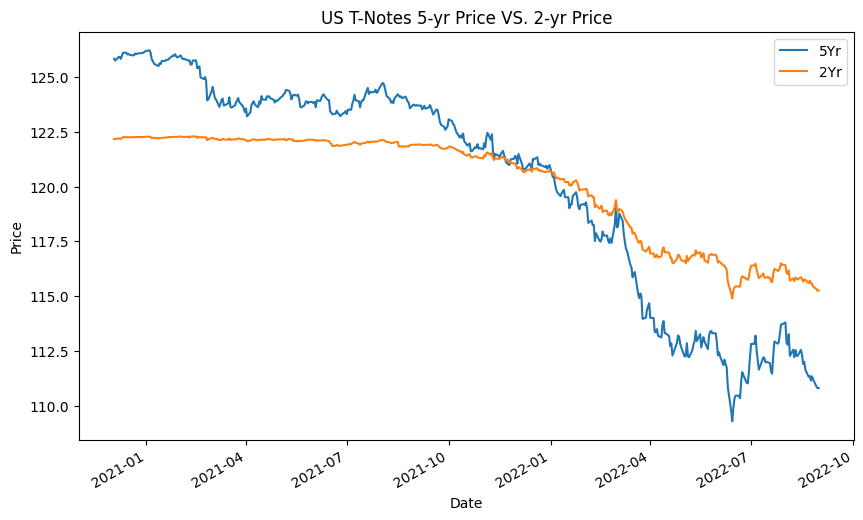

In [26]:
df_q3.plot(y=['5Yr', "2Yr"], figsize=(10, 6))
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('US T-Notes 5-yr Price VS. 2-yr Price')
plt.show()

    b. US T-Notes 5-yr Price VS. 10-yr Price

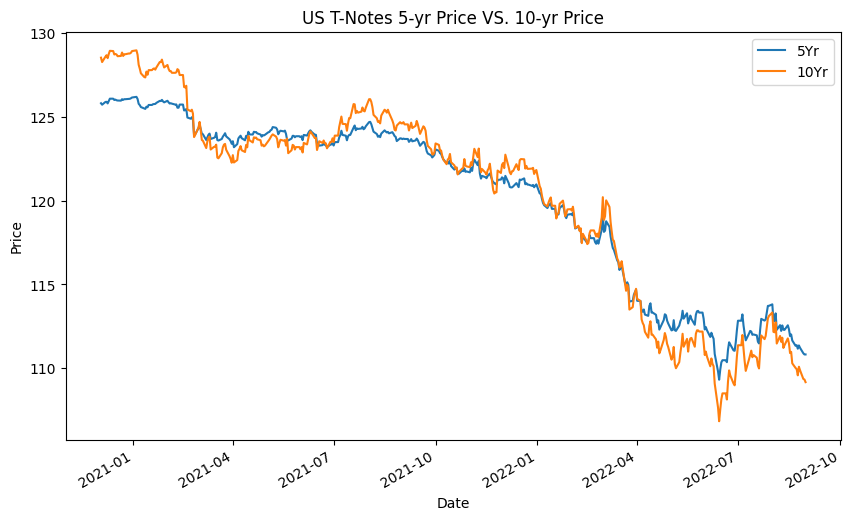

In [27]:
df_q4.plot(y=['5Yr', "10Yr"], figsize=(10, 6))
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('US T-Notes 5-yr Price VS. 10-yr Price')
plt.show()

Comments: 

In 2021, The US Economy started to recover and improved, which led to a rise in bond yields, as investors began to shift their focus from safe-haven assets to riskier assets. The Federal Reserve also began to signal that it would start to unwind its monetary stimulus measures, which also contributed to the rise in bond yields. As a result, the 2-year, 5-year, and 10-year T-notes prices fell, and the yields increased. Both charts of the 2-year, 5-year, and 10-year T-notes prices align with the facts.

In addition, in 2021 and 2022, the US Government announced several fiscal stimulus package, to support the economy, which added more supply to the market and also put some pressure on T-notes prices and yields.


We can also see from the table and from the graph that the spread between US T-Notes 2-yr Price and 5-yr Price grow from negative to postive. There is a relative wide gap between this two prices through out the time. The spread between US T-Notes 10-yr Price and 5-yr Price however is very narrow in contrast.


    c. 5-yr vs 2-yr spread and 10-day, 50-day and 100-day rolling average

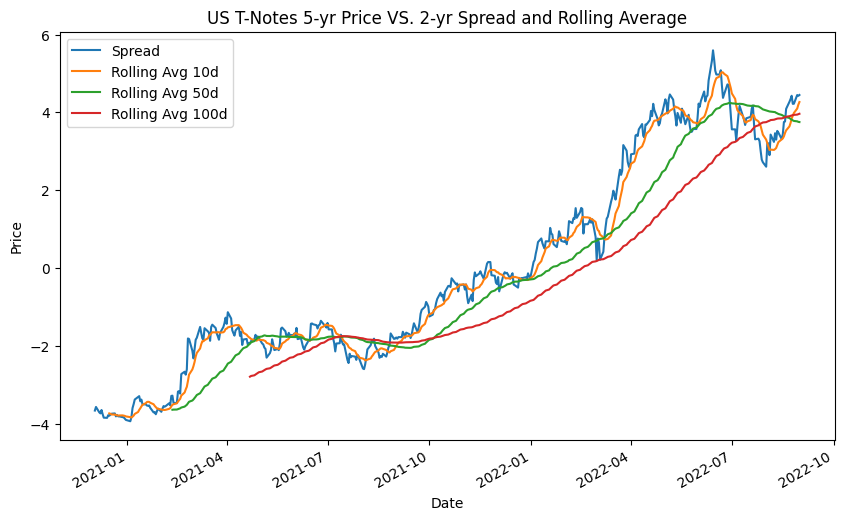

In [28]:
df_q3.plot(y=["Spread", "Rolling Avg 10d", 'Rolling Avg 50d','Rolling Avg 100d'], figsize=(10, 6))
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('US T-Notes 5-yr Price VS. 2-yr Spread and Rolling Average')
plt.show()

Comments: As we can see from the chart, the spread between US T-Notes 2-yr price and 5-yr price is increasing during the time period, this is probably due the expectation of higher inteset risk for the 3 yr gap.

    d. 5-yr vs 10-yr spread and 10-day, 50-day and 100-day rolling average

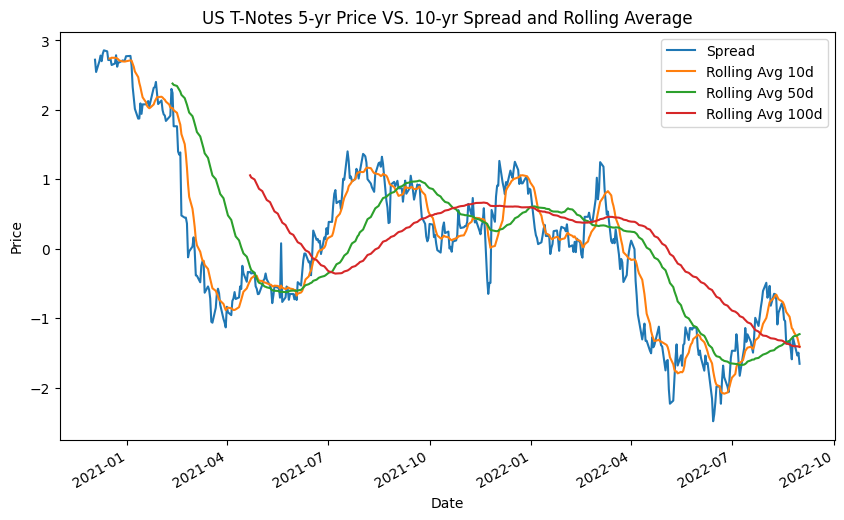

In [29]:
df_q4.plot(y=["Spread", "Rolling Avg 10d", 'Rolling Avg 50d','Rolling Avg 100d'], figsize=(10, 6))
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('US T-Notes 5-yr Price VS. 10-yr Spread and Rolling Average')
plt.show()

Comments: Since this spread is 10-Yr price - 5-Yr price, we would expect an opposite trend compared to the other sample, however, we can see the downward strength is not as strong, it is more volatile and fluctruates throughout the time.

### 3. Analyzing all the data

    a. Statistic Summary

In [30]:
# CBT_FV_FV VS. CBT_TU_TU?¿/
df_q3.describe().round(2)

,5Yr,2Yr,Spread,Rolling Avg 10d,Diff 10d,Rolling Avg 50d,Diff 50d,Rolling Avg 100d,Diff 100d
count,454.00,454.00,454.00,445.00,445.00,405.00,405.00,355.00,355.00
mean,120.17,120.14,-0.03,-0.04,0.08,-0.03,0.44,-0.12,0.87
std,5.02,2.44,2.62,2.57,0.30,2.39,0.67,2.08,0.87
min,109.31,114.91,-3.93,-3.84,-0.92,-3.64,-1.45,-2.79,-1.14
25%,114.74,117.30,-1.91,-1.86,-0.10,-1.84,-0.01,-1.83,0.29
50%,122.22,121.52,-0.68,-0.57,0.07,-0.74,0.42,-0.91,0.84
75%,123.97,122.12,2.56,2.43,0.26,1.78,0.90,1.47,1.36
max,126.20,122.28,5.59,5.03,1.09,4.25,2.06,3.96,2.98


In [31]:
# CBT_FV_FV VS. CBT_TY_TY
df_q4.describe().round(2)

,5Yr,10Yr,Spread,Rolling Avg 10d,Diff 10d,Rolling Avg 50d,Diff 50d,Rolling Avg 100d,Diff 100d
count,454.00,454.00,454.00,445.00,445.00,405.00,405.00,355.00,355.00
mean,120.17,120.26,0.10,0.09,-0.04,0.03,-0.20,0.05,-0.23
std,5.02,5.96,1.19,1.14,0.30,0.91,0.74,0.61,0.82
min,109.31,106.83,-2.48,-2.08,-1.17,-1.67,-2.17,-1.41,-2.15
25%,114.74,114.65,-0.72,-0.70,-0.21,-0.58,-0.58,-0.29,-0.85
50%,122.22,122.47,0.11,0.15,-0.02,0.28,-0.15,0.31,-0.26
75%,123.97,124.23,0.87,0.84,0.15,0.57,0.33,0.51,0.39
max,126.20,128.98,2.86,2.75,0.99,2.38,1.46,1.06,1.71


Comments: There is a negative mean of -0.03 for the 5-yr and 2-yr spread and a std of 2.62. In comparison, there is a positive mean of 0.1 for the 5-yr and 10-yr spread.

    b. Risk Analysis

In [32]:
def performance_summary(return_data):
    """ 
        Returns the Performance Stats for given set of returns
        Inputs: 
            return_data - DataFrame with Date index and Monthly Returns for different assets/strategies.
        Output:
            summary_stats - DataFrame with annualized mean return, vol, sharpe ratio. Skewness, Excess Kurtosis, Var (0.5) and
                            CVaR (0.5) and drawdown based on monthly returns. 
    """
    summary_stats = return_data.mean().to_frame('Mean').apply(lambda x: x*12)
    summary_stats['Volatility'] = return_data.std().apply(lambda x: x*np.sqrt(12))
    summary_stats['Sharpe Ratio'] = summary_stats['Mean']/summary_stats['Volatility']
    
    summary_stats['Skewness'] = return_data.skew()
    summary_stats['Excess Kurtosis'] = return_data.kurtosis()
    summary_stats['VaR (0.05)'] = return_data.quantile(.05, axis = 0)
    summary_stats['CVaR (0.05)'] = return_data[return_data <= return_data.quantile(.05, axis = 0)].mean()
    summary_stats['Min'] = return_data.min()
    summary_stats['Max'] = return_data.max()
    
    wealth_index = 1000*(1+return_data).cumprod()
    previous_peaks = wealth_index.cummax()
    drawdowns = (wealth_index - previous_peaks)/previous_peaks

    summary_stats['Max Drawdown'] = drawdowns.min()
    summary_stats['Peak'] = [previous_peaks[col][:drawdowns[col].idxmin()].idxmax() for col in previous_peaks.columns]
    summary_stats['Bottom'] = drawdowns.idxmin()
    
    recovery_date = []
    for col in wealth_index.columns:
        prev_max = previous_peaks[col][:drawdowns[col].idxmin()].max()
        recovery_wealth = pd.DataFrame([wealth_index[col][drawdowns[col].idxmin():]]).T
        recovery_date.append(recovery_wealth[recovery_wealth[col] >= prev_max].index.min())
    summary_stats['Recovery'] = recovery_date
    
    return summary_stats

In [33]:
factor_summary1 = performance_summary(df_q3)
factor_summary1.round(2)

,Mean,Volatility,Sharpe Ratio,Skewness,Excess Kurtosis,VaR (0.05),CVaR (0.05),Min,Max,Max Drawdown,Peak,Bottom,Recovery
5Yr,1441.98,17.39,82.93,-0.67,-1.09,111.57,110.86,109.31,126.20,0.000000e+00,2020-12-03,2020-12-03,2020-12-03
2Yr,1441.64,8.47,170.23,-0.81,-1.03,115.76,115.50,114.91,122.28,0.000000e+00,2020-12-03,2020-12-03,2020-12-03
Spread,-0.34,9.08,-0.04,0.47,-1.05,-3.69,-3.79,-3.93,5.59,-7.040197e+52,2021-03-03,2022-08-31,NaT
Rolling Avg 10d,-0.43,8.92,-0.05,0.48,-1.05,-3.64,-3.75,-3.84,5.03,-3.830000e+00,2020-12-31,2021-01-04,2021-01-05
Diff 10d,0.99,1.04,0.95,-0.04,1.00,-0.39,-0.59,-0.92,1.09,-1.000000e+00,2022-06-21,2022-08-04,NaT
Rolling Avg 50d,-0.42,8.28,-0.05,0.61,-0.98,-3.08,-3.43,-3.64,4.25,-3.630000e+00,2021-02-12,2021-02-15,2021-02-16
Diff 50d,5.32,2.32,2.29,0.06,-0.28,-0.59,-0.87,-1.45,2.06,-1.000000e+00,2022-06-29,2022-07-27,NaT
Rolling Avg 100d,-1.47,7.20,-0.20,0.70,-0.91,-2.47,-2.63,-2.79,3.96,-6.286106e+13,2021-06-22,2022-08-31,NaT
Diff 100d,10.39,3.02,3.44,0.28,-0.30,-0.51,-0.70,-1.14,2.98,-1.000000e+00,2022-07-21,2022-07-29,NaT


Comments:

The spread between 5-year and 2-year US Treasury note (T-note) prices has a mean of -0.34, which indicates that the 2-year T-note is trading at a slight discount to the 5-year T-note. This could suggest a potential mean-reversion strategy where you would buy the 2-year T-note and sell the 5-year T-note, with the expectation that the spread will eventually revert back to its mean.

The volatility of the spread is 9.08, which indicates that the spread changes relatively frequently. A high volatility suggests that the spread can change rapidly and therefore a strategy that's based on volatility, such as a volatility breakout strategy, could be profitable.

The Sharpe Ratio of the spread is -0.04, which indicates that the returns of the spread are not well-adjusted to the level of risk. This could suggest that the spread may not be a good candidate for a long-term strategy.

The skewness of the spread is 0.467, which indicates that the spread is slightly skewed to the right.

The excess kurtosis of the spread is -1.05, which indicates that the spread has a flatter distribution than a normal distribution.

VaR (0.05) for the spread is -3.69, which indicates that the maximum loss that can be expected for the spread with a 5% probability is -3.69.

CVaR (0.05) for the spread is -3.791, which indicates that the expected loss that can be expected for the spread with a 5% probability is -3.79.

In [34]:
factor_summary2 = performance_summary(df_q4)
factor_summary2.round(2)

,Mean,Volatility,Sharpe Ratio,Skewness,Excess Kurtosis,VaR (0.05),CVaR (0.05),Min,Max,Max Drawdown,Peak,Bottom,Recovery
5Yr,1441.98,17.39,82.93,-0.67,-1.09,111.57,110.86,109.31,126.20,0.00,2020-12-03,2020-12-03,2020-12-03
10Yr,1443.17,20.63,69.95,-0.60,-0.91,110.01,109.04,106.83,128.98,0.00,2020-12-03,2020-12-03,2020-12-03
Spread,1.19,4.13,0.29,0.33,-0.33,-1.66,-1.98,-2.48,2.86,-8.33,2021-03-02,2022-03-18,NaT
Rolling Avg 10d,1.06,3.95,0.27,0.31,-0.28,-1.70,-1.89,-2.08,2.75,-1.00,2022-03-24,2022-04-18,NaT
Diff 10d,-0.52,1.03,-0.50,-0.42,0.95,-0.54,-0.73,-1.17,0.99,-1.00,2020-12-16,2021-02-19,NaT
Rolling Avg 50d,0.31,3.16,0.10,-0.11,-0.21,-1.59,-1.64,-1.67,2.38,-1.00,2022-04-15,2022-05-23,NaT
Diff 50d,-2.43,2.57,-0.95,-0.55,0.00,-1.72,-1.91,-2.17,1.46,-1.00,2021-02-11,2021-02-19,NaT
Rolling Avg 100d,0.65,2.12,0.30,-0.97,-0.09,-1.29,-1.35,-1.41,1.06,-1.00,2022-05-03,2022-07-05,NaT
Diff 100d,-2.72,2.83,-0.96,0.01,-0.60,-1.54,-1.74,-2.15,1.71,-1.34,2021-04-23,2021-04-26,NaT


Comments: 

The mean of the spread between the 5-year and 10-year US Treasury note (T-note) prices is 1.19 which indicates that the 10-year T-note is trading at a slight premium to the 5-year T-note. This could suggest a potential mean-reversion strategy where you would sell the 10-year T-note and buy the 5-year T-note, with the expectation that the spread will eventually revert back to its mean.

The volatility of the spread is 4.13, which indicates that the spread changes relatively frequently. The volatility suggest that the spread can change rapidly and therefore a strategy that's based on volatility, such as a volatility breakout strategy, could be profitable.

The Sharpe ratio of the spread is 0.29, which indicates that the returns of the spread are well-adjusted to the level of risk. This could suggest that the spread is a good candidate for a long-term strategy.

The max drawdown is -8.33, which indicates that the spread experienced a drop. Thus, it could be important to use risk management techniques, such as stop loss orders, to limit potential losses.

    C. Correlation
    

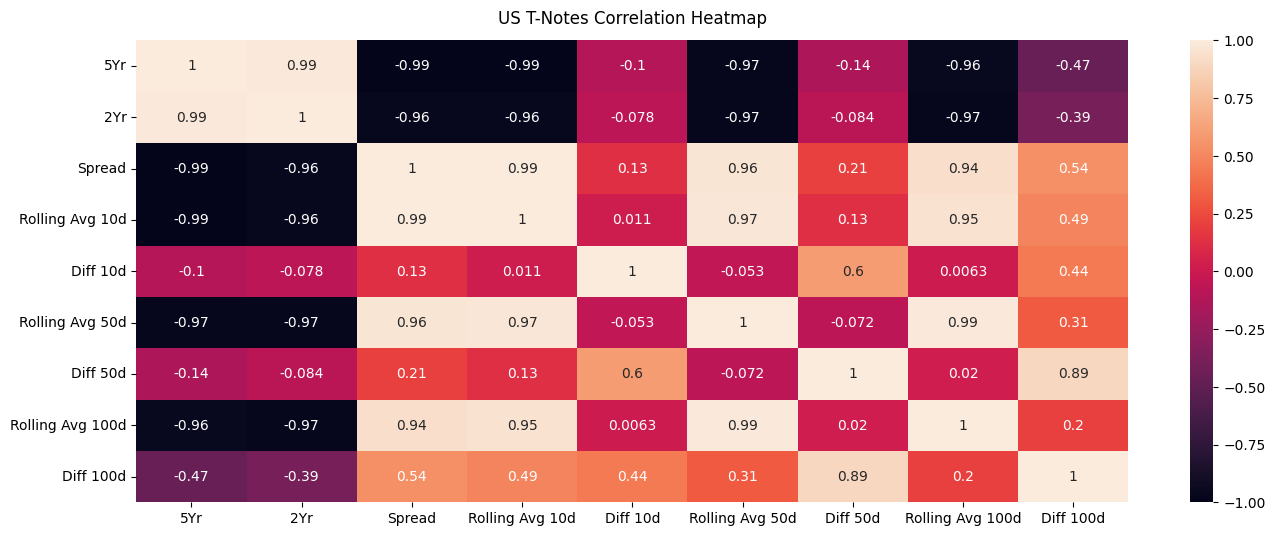

In [35]:
corr1 = df_q3.corr()
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(corr1, vmin=-1, vmax=1, annot=True)
heatmap.set_title('US T-Notes Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

Comments: The spread is negatively correlated to both 5-Yr and 2-Yr T-Notes rate, and is positively correlated with the diff between rolling avg. 

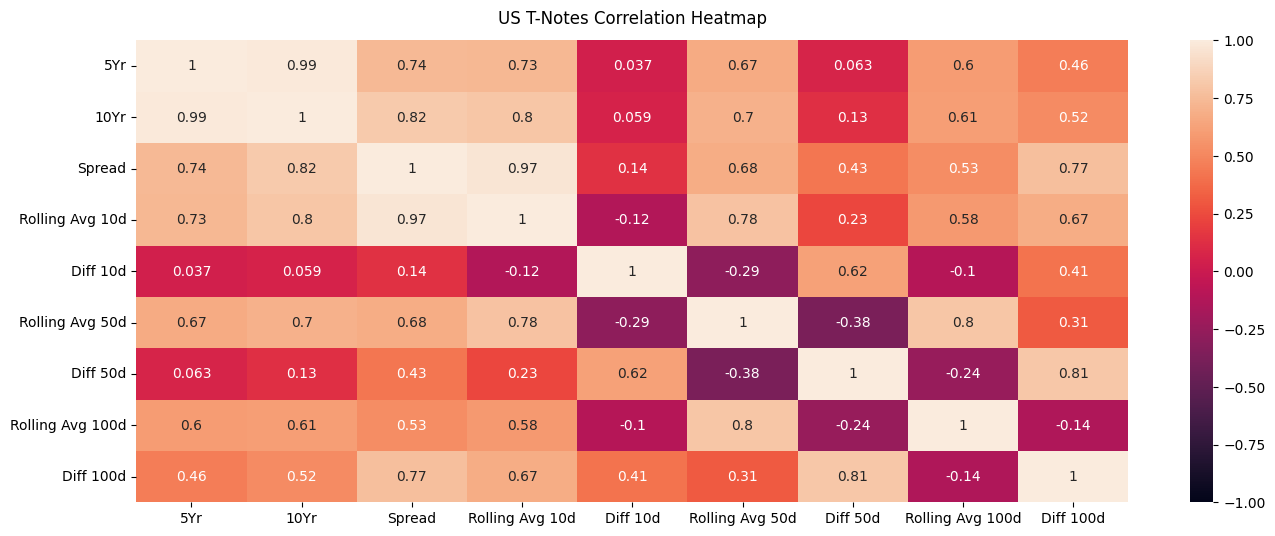

In [36]:
corr2 = df_q4.corr()
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(corr2, vmin=-1, vmax=1, annot=True)
heatmap.set_title('US T-Notes Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

Comments: We can see a positive correlation between spread and both 5-Yr, 10-Yr US T-Notes, as well as the diff between rolling avg.

    D. Calculate the autocorrelation of the time series

In [37]:
autocorr1 = df_q3['Spread'].autocorr()
autocorr1

0.9973310116308433

In [38]:
autocorr2 = df_q4['Spread'].autocorr()
autocorr2

0.9867162877274319

Comments: Both autocorrelations represent a very high degree of similarity between the given time series of spreads and a lagged version of itself over successive time intervals.
We can see from the results that there is a very high influence on past prices for the T-Notes have on its future price.

### 4.Machine Learning Analysis

In [39]:
# Create the feature and target arrays
X = df_q3["2Yr"].values.reshape(-1, 1)
y = df_q3["5Yr"].values

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the linear regression model
reg = LinearRegression().fit(X_train, y_train)

# Make predictions on the test set
y_pred = reg.predict(X_test)

# Calculate the mean squared error and R^2 score
mse = mean_squared_error(y_test, y_pred).round(2)
r2 = r2_score(y_test, y_pred).round(2)

# Print the results
print("Mean Squared Error: ", mse)
print("R^2 Score: ", r2)

Mean Squared Error:  0.54
R^2 Score:  0.98


In [40]:
# Create the feature and target arrays
X = df_q4["5Yr"].values.reshape(-1, 1)
y = df_q4["10Yr"].values

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the linear regression model
reg = LinearRegression().fit(X_train, y_train)

# Make predictions on the test set
y_pred = reg.predict(X_test)

# Calculate the mean squared error and R^2 score
mse = mean_squared_error(y_test, y_pred).round(2)
r2 = r2_score(y_test, y_pred).round(2)

# Print the results
print("Mean Squared Error: ", mse)
print("R^2 Score: ", r2)

Mean Squared Error:  0.72
R^2 Score:  0.98


Comments:

A relatively low Mean Squared Error (MSE) suggests that the model is not fitting the data as well as it could be. A high MSE means that the model's predictions are far from the true values, on average.

The R^2 score of 0.98 suggests that the model explains about 98% of the variation in the target variable, which is a relatively high level of explanation.

To sum up, the results suggest that the linear regression model is able to fit the data well, and can explain a significant amount of the variation in the target variable.